**Run on Google Colab (Runtime type: T4 GPU)**

To confirm the T4 is visible

In [1]:
!nvidia-smi

Sun Oct  5 16:51:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Generate Synthetic Sentiment Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
!pip install mlflow

In [ ]:
import re
import time
import random
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.special import softmax
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import mlflow

# Configure warnings after all imports
warnings.filterwarnings("ignore")

In [5]:
# Pick GPU if available; on Colab T4 this should be 'cuda'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


Save the experiment in MLflow

In [6]:
mlflow.set_tracking_uri("https://4c7ef9cead83.ngrok-free.app")
mlflow.set_experiment("SentimentAnalysisRoberta")

<Experiment: artifact_location='mlflow-artifacts:/372581362542727863', creation_time=1759646563278, experiment_id='372581362542727863', last_update_time=1759646563278, lifecycle_stage='active', name='SentimentAnalysisRoberta', tags={}>

In [7]:
train = pd.read_csv('/content/drive/MyDrive/! Chatbot Credit Risk/dataset/application_train.csv')
test = pd.read_csv('/content/drive/MyDrive/! Chatbot Credit Risk/dataset/application_test.csv')

In [8]:
train.shape, test.shape

((307511, 122), (48744, 121))

In [9]:
# Add an identifier so we know where each row came from
train['is_train'] = True
test['is_train'] = False

In [10]:
# Add a placeholder for the target in test so columns align
test['TARGET'] = None

In [11]:
# Combine the datasets
df = pd.concat([train, test], ignore_index=True)

In [12]:
df.tail()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train
356250,456221,None,Cash loans,F,N,Y,0,121500.0,412560.0,17473.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,False
356251,456222,None,Cash loans,F,N,N,2,157500.0,622413.0,31909.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False
356252,456223,None,Cash loans,F,Y,Y,1,202500.0,315000.0,33205.5,...,0,0,0,0.0,0.0,0.0,0.0,3.0,1.0,False
356253,456224,None,Cash loans,M,N,N,0,225000.0,450000.0,25128.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,2.0,False
356254,456250,None,Cash loans,F,Y,N,0,135000.0,312768.0,24709.5,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,False


In [ ]:
df[df['is_train']].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0,True
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,True
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,True
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,True
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,True


In [ ]:
df[~df['is_train']].head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,is_train
307511,100001,None,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,False
307512,100005,None,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,False
307513,100013,None,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,...,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0,False
307514,100028,None,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,...,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,False
307515,100038,None,Cash loans,M,Y,N,1,180000.0,625500.0,32067.0,...,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,False


In [15]:
df.shape

(356255, 123)

Synthetic Sentimen Data Function

In [16]:
# Expand the function with more variation and randomness for 1M rows
# We simulate only a subset here due to resource constraints but structure it for large-scale generation

def generate_richer_comment(row):
    # Phrase pools for various conditions
    defaulted_phrases = [
        "i've been behind on my payments, it's stressful",
        "lost my job recently...trying to catch up",
        "money's tight lately, trying my best",
        "wasn't expecting bills to stack up like this",
        "things spiraled after I got laid off, it's rough",
        "sorry for the delays, I'm struggling financially",
        "it's hard juggling expenses with kids and low income"
    ]

    positive_phrases = [
        "no problems with my loans, always on time",
        "stable job, steady payments, nothing to worry about",
        "my finances are in good shape, no issues at all",
        "been employed long-term, confident about repayments",
        "i handle my debts responsibly",
        "always make sure my credit's in order",
        "never had any trouble keeping up with loans"
    ]

    pensioner_phrases = [
        "even in retirement, I manage to pay everything",
        "i live on a fixed income but always budget well",
        "pension covers the basics, I plan carefully",
        "i'm retired but handle my dues just fine"
    ]

    hardship_with_kids = [
        f"i got {row['CNT_CHILDREN']} kids, every bit counts",
        f"supporting {row['CNT_CHILDREN']} children on this income is hard",
        f"taking care of {row['CNT_CHILDREN']} little ones and paying bills ain't easy"
    ]

    neutral_phrases = [
        "doing okay, just trying to keep everything balanced",
        "not rich, but i try to manage responsibly",
        "things are manageable, i keep track of my payments",
        "staying afloat, no major problems"
    ]

    comment_parts = []

    # Logic-based phrase selection
    if row['TARGET'] == 1:
        comment_parts.append(random.choice(defaulted_phrases))
        # This generates a random float between 0.0 and 1.0 and
        # checks if it's less than 0.7 which happens with 70% probability.
        if row['CNT_CHILDREN'] > 0 and random.random() < 0.7:
            comment_parts.append(random.choice(hardship_with_kids))
        if row['AMT_INCOME_TOTAL'] < 100000 and random.random() < 0.5:
            comment_parts.append("low income makes it extra tough")
    else:
        if row['NAME_INCOME_TYPE'] == "Pensioner":
            comment_parts.append(random.choice(pensioner_phrases))
        elif row['DAYS_EMPLOYED'] < -1500 and row['AMT_INCOME_TOTAL'] > 150000:
            comment_parts.append(random.choice(positive_phrases))
        else:
            if random.random() < 0.5:
                comment_parts.append(random.choice(positive_phrases))
            else:
                comment_parts.append(random.choice(neutral_phrases))

    # Introduce casual formatting and messiness
    text = " ".join(comment_parts)
    text = text.replace("i ", "I ").replace("...", ".").replace("ain't", "aint")
    text = text.replace("gonna", "gonna").replace("got", "got").replace("trying", "tryna")
    if random.random() < 0.3:
        text = text.lower()
    if random.random() < 0.2:
        text = text.replace(" ", "  ")  # add spacing issues
    if random.random() < 0.1:
        text = text + "..."  # trailing ellipsis

    return text.strip()


Apply the Function

In [17]:
df['COMMENT'] = df.apply(generate_richer_comment, axis=1)

# Text Preprocessing

In [18]:
df[['TARGET', 'NAME_INCOME_TYPE', 'AMT_INCOME_TOTAL', 'DAYS_EMPLOYED', 'CNT_CHILDREN', 'EXT_SOURCE_3', 'COMMENT']].sample(5)

,TARGET,NAME_INCOME_TYPE,AMT_INCOME_TOTAL,DAYS_EMPLOYED,CNT_CHILDREN,EXT_SOURCE_3,COMMENT
179640,1,Working,225000.0,-905,0,NaN,"things spiraled after I got laid off, it's rough"
355376,None,State servant,135000.0,-915,0,NaN,always make sure my credit's in order...
161211,0,Pensioner,76500.0,365243,0,0.475850,"pension covers the basics, I plan carefully"
191767,0,Pensioner,166500.0,365243,0,0.636376,"pension covers the basics, I plan carefully"
72474,0,Pensioner,85500.0,365243,0,0.612704,i live on a fixed income but always budget well


In [19]:
df['COMMENT'].dtype

dtype('O')

## Handling Duplicate Data

In [20]:
# show all duplicate features
df.duplicated().sum().sum()

np.int64(0)

## Handling Missing Values

In [21]:
df['COMMENT'].isna().sum().sum()

np.int64(0)

## Handling Error Data

In [22]:
pd.set_option('display.max_rows', None)

In [23]:
df['COMMENT'].value_counts().sort_index(ascending=True)

,count
COMMENT,
I handle my debts responsibly,3227
I handle my debts responsibly...,353
I live on a fixed income but always budget well,1984
I live on a fixed income but always budget well...,235
I handle my debts responsibly,12751
I handle my debts responsibly...,1396
I live on a fixed income but always budget well,7916
I live on a fixed income but always budget well...,822
always make sure my credit's in order,4556


## Text Cleaning

In [24]:
def basic_clean(text: str) -> str:

    # 1. lowercasing
    text = text.lower()

    # 2. remove ellipsis (...)
    text = text.replace("...", "")

    # 3. ensure single space after a period if missing
    # e.g. "good.morning" -> "good. morning"
    text = re.sub(r"\.(?=[^\s])", ". ", text)

    # 4. replace 'tryna' with 'trying to'
    text = re.sub(r"\btryna\b", "trying to", text)

    # 5. normalize multiple spaces -> single space
    text = re.sub(r"\s+", " ", text).strip()

    return text

In [25]:
df["COMMENT_CLEAN"] = df["COMMENT"].apply(basic_clean)

In [26]:
df['COMMENT_CLEAN'].value_counts().sort_index(ascending=True)

,count
COMMENT_CLEAN,
always make sure my credit's in order,25487
"been employed long-term, confident about repayments",24976
"doing okay, just trying to to keep everything balanced",23165
"even in retirement, i manage to pay everything",15257
i handle my debts responsibly,25197
i live on a fixed income but always budget well,15645
i'm retired but handle my dues just fine,15465
"i've been behind on my payments, it's stressful",2475
"i've been behind on my payments, it's stressful i got 1 kids, every bit counts",155


In [27]:
# Disable column width truncation
pd.set_option('display.max_colwidth', None)

In [28]:
df[["SK_ID_CURR", "COMMENT", "COMMENT_CLEAN"]].sample(10)

,SK_ID_CURR,COMMENT,COMMENT_CLEAN
145846,269107,"my finances are in good shape, no issues at all","my finances are in good shape, no issues at all"
140604,263036,always make sure my credit's in order,always make sure my credit's in order
345866,381691,i'm retired but handle my dues just fine,i'm retired but handle my dues just fine
221481,356557,always make sure my credit's in order,always make sure my credit's in order
324741,224849,I live on a fixed income but always budget well,i live on a fixed income but always budget well
250224,389521,"things are manageable, I keep track of my payments...","things are manageable, i keep track of my payments"
207422,340412,"staying afloat, no major problems","staying afloat, no major problems"
183852,313100,"been employed long-term, confident about repayments","been employed long-term, confident about repayments"
330080,264087,i handle my debts responsibly,i handle my debts responsibly
350986,416582,"doing okay, just tryna to keep everything balanced","doing okay, just trying to to keep everything balanced"


# Model Building

In [29]:
def summarize_predictions(df):
    counts = df["sentiment"].value_counts()
    total = len(df)
    pct = (counts / total * 100).round(2)
    mean_conf = float(df["score_confidence"].mean())
    # Return plain dicts so logging is easy
    return {
        "total_rows": int(total),
        "count_negative": int(counts.get("negative", 0)),
        "count_neutral": int(counts.get("neutral", 0)),
        "count_positive": int(counts.get("positive", 0)),
        "pct_negative": float(pct.get("negative", 0.0)),
        "pct_neutral": float(pct.get("neutral", 0.0)),
        "pct_positive": float(pct.get("positive", 0.0)),
        "mean_confidence": mean_conf,
    }

In [30]:
model_name = "cardiffnlp/twitter-roberta-base-sentiment-latest"

In [31]:
# Fast tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)

In [32]:
# Use FP16 on GPU for faster inference and lower memory.
# Pick dtype based on device (FP16 on GPU, FP32 on CPU)
load_dtype = torch.float16 if device.type == "cuda" else torch.float32

In [33]:
# Load model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    dtype=load_dtype,
).to(device)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [34]:
model.eval()

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [35]:
labels = ["negative", "neutral", "positive"]

In [36]:
print("Loaded:", model_name)
print("Device:", device)
print("Dtype :", load_dtype)

Loaded: cardiffnlp/twitter-roberta-base-sentiment-latest
Device: cuda
Dtype : torch.float16


# Batch prediction

In [37]:
@torch.inference_mode()
def predict_roberta(texts, batch_size=64, max_length=256):
    all_probs, all_idx = [], []

    for start in range(0, len(texts), batch_size):
        batch_texts = texts[start:start+batch_size].tolist()
        enc = tokenizer(
            batch_texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_length,
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        if device.type == "cuda":
            with torch.autocast(device_type="cuda", dtype=torch.float16):
                logits = model(**enc).logits
        else:
            logits = model(**enc).logits

        probs = softmax(logits.detach().cpu().numpy(), axis=1)
        all_probs.append(probs)
        all_idx.append(np.argmax(probs, axis=1))

    scores = np.vstack(all_probs)
    pred_idx = np.concatenate(all_idx)
    pred_label = [labels[i] for i in pred_idx]
    return {"pred_label": pred_label, "scores": scores}

In [38]:
batch_size = 64
max_length = 256

In [39]:
run_params = {
    "model_name": model_name,
    "batch_size": batch_size,
    "max_length": max_length,
    "device": str(device),
    "cleaning_rules": "lowercase; remove '...'; add space after '.'; normalize spaces; 'tryna'->'trying to'",
}

In [ ]:
# texts = df["COMMENT_CLEAN"].head(100000) # 100000 Samples

# 100000 rows -> 31 s
# 356255 rows -> ~ 2 minutes

In [40]:
start = time.time()

In [41]:
%%time
texts = df["COMMENT_CLEAN"] # All Samples
result = predict_roberta(texts, batch_size=batch_size, max_length=max_length)

CPU times: user 1min 47s, sys: 1.05 s, total: 1min 48s
Wall time: 1min 58s


In [42]:
df["sentiment"]       = result["pred_label"]
df["score_negative"]  = result["scores"][:, 0]
df["score_neutral"]   = result["scores"][:, 1]
df["score_positive"]  = result["scores"][:, 2]
df["score_confidence"] = result["scores"].max(axis=1)  # max probability among the three

In [43]:
df[["SK_ID_CURR", "COMMENT", "sentiment", "score_negative", "score_neutral", "score_positive", "score_confidence"]].head(10)

,SK_ID_CURR,COMMENT,sentiment,score_negative,score_neutral,score_positive,score_confidence
0,100002,"money's tight lately, tryna my best",negative,0.647461,0.308350,0.044128,0.647461
1,100003,"stable job, steady payments, nothing to worry about",positive,0.024048,0.331299,0.645020,0.645020
2,100004,"not rich, but i try to manage responsibly",neutral,0.084778,0.562988,0.352295,0.562988
3,100006,"no problems with my loans, always on time",positive,0.027649,0.189575,0.782715,0.782715
4,100007,"staying afloat, no major problems",positive,0.040558,0.437256,0.521973,0.521973
5,100008,i handle my debts responsibly,neutral,0.083984,0.655273,0.260986,0.655273
6,100009,I handle my debts responsibly,neutral,0.083984,0.655273,0.260986,0.655273
7,100010,"doing okay, just tryna to keep everything balanced",positive,0.024704,0.317627,0.657715,0.657715
8,100011,i'm retired but handle my dues just fine,positive,0.045868,0.444336,0.509766,0.509766
9,100012,"staying afloat, no major problems",positive,0.040558,0.437256,0.521973,0.521973


# Sentiment Example Results

In [44]:
# label distribution and examples for each class

counts = df["sentiment"].value_counts()
percent = (counts / len(df) * 100).round(2)

print("Label counts:\n", counts)
print("\nLabel percentages (%):\n", percent.to_dict())

Label counts:
 sentiment
positive    201212
neutral     130936
negative     24107
Name: count, dtype: int64

Label percentages (%):
 {'positive': 56.48, 'neutral': 36.75, 'negative': 6.77}


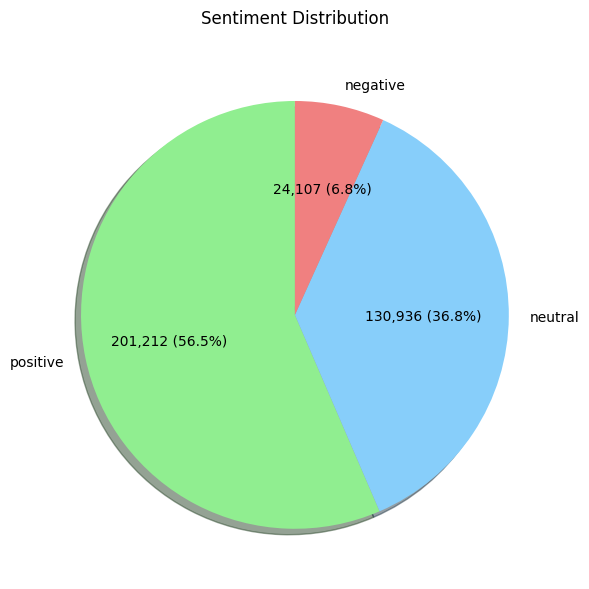

In [59]:
# Function to format both count and percentage with commas
def autopct_format(values):
    def inner_autopct(pct):
        total = sum(values)
        count = int(round(pct * total / 100.0))
        return f"{count:,} ({pct:.1f}%)"
    return inner_autopct

# Create pie chart
plt.figure(figsize=(6, 6))
plt.pie(
    counts,
    labels=counts.index,
    autopct=autopct_format(counts),
    startangle=90,
    colors=['lightgreen', 'lightskyblue', 'lightcoral'],
    shadow=True
)

plt.title("Sentiment Distribution", pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

In [46]:
def show_examples(label, n=5):
    cols = ["SK_ID_CURR", "COMMENT", "sentiment", "score_confidence"]
    return df[df["sentiment"] == label][cols].sample(n)

In [47]:
print("Examples — NEGATIVE:")
display(show_examples("negative", 5))

Examples — NEGATIVE:


,SK_ID_CURR,COMMENT,sentiment,score_confidence
71795,183251,wasn't expecting bills to stack up like this low income makes it extra tough...,negative,0.773926
304062,452288,"sorry for the delays, i'm struggling financially low income makes it extra tough",negative,0.878418
243036,381332,"sorry for the delays, I'm struggling financially",negative,0.867188
166990,293589,"sorry for the delays, I'm struggling financially supporting 2 children on this income is hard",negative,0.824707
282115,426754,"sorry for the delays, i'm struggling financially...",negative,0.867188


In [48]:
print("Examples — NEUTRAL:")
display(show_examples("neutral", 5))

Examples — NEUTRAL:


,SK_ID_CURR,COMMENT,sentiment,score_confidence
201653,333755,i handle my debts responsibly,neutral,0.655273
271348,414567,always make sure my credit's in order...,neutral,0.492188
146993,270427,never had any trouble keeping up with loans,neutral,0.619141
49229,156991,"pension covers the basics, I plan carefully",neutral,0.543457
44943,152061,never had any trouble keeping up with loans,neutral,0.619141


In [49]:
print("Examples — POSITIVE:")
display(show_examples("positive", 5))

Examples — POSITIVE:


,SK_ID_CURR,COMMENT,sentiment,score_confidence
216803,351204,"stable job, steady payments, nothing to worry about",positive,0.645020
189417,319619,"no problems with my loans, always on time",positive,0.782227
268195,410768,"staying afloat, no major problems",positive,0.521484
142303,264998,"things are manageable, I keep track of my payments",positive,0.753418
330541,267405,"my finances are in good shape, no issues at all",positive,0.864258


# Save The CSV File

In [ ]:
# # Recover the train and test sets
# train = df[df['is_train']].copy().reset_index(drop=True)
# test = df[~df['is_train']].copy().reset_index(drop=True)

In [50]:
out_cols = [
    "SK_ID_CURR",
    "COMMENT",
    "sentiment",
    "score_negative",
    "score_neutral",
    "score_positive",
    "score_confidence",
]
out_df = df[out_cols].copy()

In [51]:
output_path = "/content/drive/MyDrive/! Chatbot Credit Risk/sentiment_dataset/sentiment_results.csv"
out_df.to_csv(output_path, index=False)
print("Saved to:", output_path)

Saved to: /content/drive/MyDrive/! Chatbot Credit Risk/sentiment_dataset/sentiment_results.csv


## MLflow

Since we’re just doing inference (no training), **MLflow** is mainly for tracking what we ran, with what settings, and what came out. We’ll keep it simple:
- log basic **params** (model name, batch size, max length, device)
- log basic **metrics** (rows processed, class counts/percentages, mean confidence, runtime, rows/sec)
- log **artifacts** (the output CSV and a tiny sample preview)

In [52]:
# small preview file as artifact
preview_path = "/content/drive/MyDrive/! Chatbot Credit Risk/sentiment_dataset/predictions_sample.csv"
out_df.head(50).to_csv(preview_path, index=False)

In [53]:
elapsed = time.time() - start
rows = len(out_df)
throughput = rows / elapsed if elapsed > 0 else float("inf")

In [54]:
# Summaries for metrics
summary = summarize_predictions(out_df)
summary.update({
    "runtime_seconds": float(round(elapsed, 3)),
    "rows_per_second": float(round(throughput, 2)),
})

In [55]:
# Log to MLflow
with mlflow.start_run(run_name="roberta_inference"):
    # params
    mlflow.log_params(run_params)

    # metrics
    mlflow.log_metrics(summary)

    # artifacts
    mlflow.log_artifact(output_path)   # full predictions
    mlflow.log_artifact(preview_path)  # small preview

print("Saved CSV:", Path(output_path).resolve())
print("Logged run with params+metrics to MLflow.")
print("Summary:", summary)

🏃 View run roberta_inference at: https://4c7ef9cead83.ngrok-free.app/#/experiments/372581362542727863/runs/acb21e40733945cf9b639901fee6fb00
🧪 View experiment at: https://4c7ef9cead83.ngrok-free.app/#/experiments/372581362542727863
Saved CSV: /content/drive/MyDrive/! Chatbot Credit Risk/sentiment_dataset/sentiment_results.csv
Logged run with params+metrics to MLflow.
Summary: {'total_rows': 356255, 'count_negative': 24107, 'count_neutral': 130936, 'count_positive': 201212, 'pct_negative': 6.77, 'pct_neutral': 36.75, 'pct_positive': 56.48, 'mean_confidence': nan, 'runtime_seconds': 127.104, 'rows_per_second': 2802.86}


# Single-sample Inference

In [56]:
def predict_single(text: str):
    """
    Run sentiment prediction on a single input text using the loaded RoBERTa model.
    Returns: label, confidence, and full probability breakdown.
    """
    # Apply same cleaning as before
    clean_text = basic_clean(text)

    # Run through batch function (wrap in list)
    result = predict_roberta(pd.Series([clean_text]), batch_size=1)

    label = result["pred_label"][0]
    probs = result["scores"][0]
    confidence = probs.max()

    # Pack into a simple dict
    return {
        "text_clean": clean_text,
        "sentiment": label,
        "confidence": round(float(confidence), 4),
        "negative": round(float(probs[0]), 4),
        "neutral": round(float(probs[1]), 4),
        "positive": round(float(probs[2]), 4),
    }

In [57]:
text = "I'm tryna finish this project... it's taking forever!"
res = predict_single(text)

In [58]:
print("Original :", text)
print("Cleaned  :", res["text_clean"])
print("Sentiment:", res["sentiment"])
print("Confidence:", res["confidence"])
print("Scores -> Neg:", res["negative"],
      "| Neu:", res["neutral"],
      "| Pos:", res["positive"])

Original : I'm tryna finish this project... it's taking forever!
Cleaned  : i'm trying to finish this project it's taking forever!
Sentiment: negative
Confidence: 0.8013
Scores -> Neg: 0.8013 | Neu: 0.1715 | Pos: 0.0272
